In [1]:
import pandas as pd
import json
import numpy as np
import os
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn import metrics
import time
import optuna
from optuna.samplers import RandomSampler
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import catboost as cb

rs = 42

In [2]:
obj = pd.read_csv('akb_obj_features_snad4.csv')
target = obj['label']
data = obj[obj.columns[2:]]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=rs, shuffle=True)


# RandomForest

In [4]:
rf = RandomForestClassifier(max_depth=18, n_estimators=830, random_state=rs)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, n_estimators=830, random_state=42)

In [8]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [13]:
feature_names = np.arange(54)#list(data.columns)

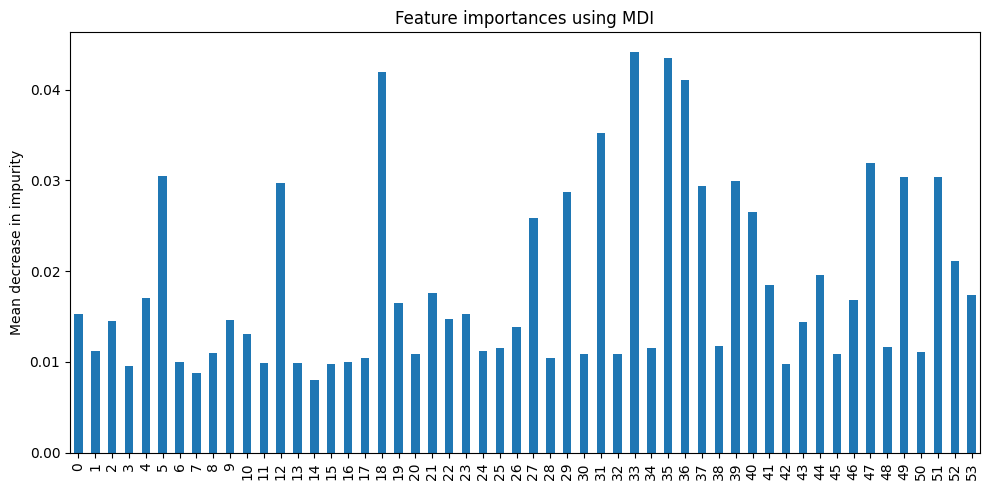

In [21]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# CatBoost

In [16]:
params = {'objective': 'CrossEntropy',
 'colsample_bylevel': 0.06813255171984411,
 'depth': 7,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 1.5285913918433203}

catboost = cb.CatBoostClassifier(**params, random_state=rs, verbose=0)
catboost.fit(X_train, y_train)

<BarContainer object of 54 artists>

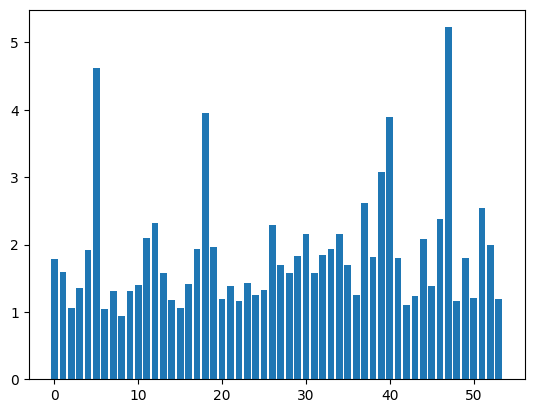

In [20]:
cb_imp = catboost.get_feature_importance()
plt.bar(np.arange(54), cb_imp)

# ExtraTrees

In [22]:
extratrees = ExtraTreesClassifier(max_depth=39, n_estimators=251, max_features=1, random_state=rs)
extratrees.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=39, max_features=1, n_estimators=251,
                     random_state=42)

In [23]:
importances = extratrees.feature_importances_
std = np.std([tree.feature_importances_ for tree in extratrees.estimators_], axis=0)

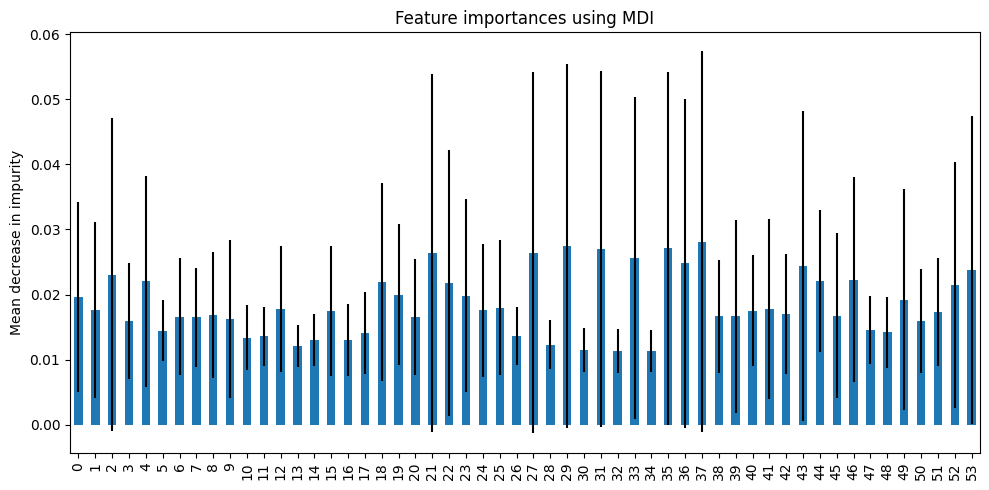

In [24]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# XGBoost

In [25]:
params = {'booster': 'dart',
 'lambda': 2.81750392241178e-07,
 'alpha': 3.403847848402039e-08,
 'subsample': 0.7928965194320472,
 'colsample_bytree': 0.6595784905439295,
 'max_depth': 9,
 'min_child_weight': 3,
 'eta': 0.023021758555949304,
 'gamma': 4.10221634196052e-07,
 'grow_policy': 'lossguide',
 'sample_type': 'uniform',
 'normalize_type': 'tree',
 'rate_drop': 0.10413682357387563,
 'skip_drop': 1.3789891825667776e-05}

xgboost = xgb.XGBClassifier(**params, random_state=rs)
xgboost.fit(X_train, y_train)

XGBClassifier(alpha=3.403847848402039e-08, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6595784905439295, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.023021758555949304, eval_metric=None, feature_types=None,
              gamma=4.10221634196052e-07, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              lambda=2.81750392241178e-07, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

In [27]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [28]:
get_xgb_imp(xgboost,feature_names)

TypeError: 'str' object is not callable